## Developing KNN code

In [1]:
# General imports
import torch
import numpy as np
import os, sys
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image

In [2]:
# Local imports
sys.path.insert(0, 'src')
from utils.analysis import knn
from utils import read_json
from parse_config import ConfigParser
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer.editor import Editor
from utils import prepare_device, copy_file, read_paths #, show_image
from utils.visualizations import show_image
sys.path.insert(0, os.path.join('external_code', 'EditingClassifiers'))
from helpers.context_helpers import fea

In [18]:
# Define constants, paths
# config_path = 'configs/cinic10_imagenet_edit.json'
config_path = 'configs/debug/cinic10_imagenet_edit_debug.json'
base_image_path = 'data/editing/dummy/tank1.jpg'

In [19]:
# Load config file, models, and dataloader
config_json = read_json(config_path)
config = ConfigParser(config_json)

layernum = config.config['layernum']
model = config.init_obj('arch', module_arch, layernum=layernum)
print(config.config['data_loader'])
val_data_loader = config.init_obj('data_loader', module_data, split='valid')
test_data_loader = config.init_obj('data_loader', module_data, split='test')

OrderedDict([('type', 'CINIC10DataLoader'), ('args', OrderedDict([('data_dir', 'data/cinic-10-imagenet-dummy'), ('batch_size', 64), ('shuffle', False), ('normalize', False), ('num_workers', 8), ('return_paths', True)]))])


In [20]:
# Load and resize image
def load_image(image_path, resize=None):
    image = Image.open(image_path).convert("RGB")
    if resize is not None:
        image = image.resize(resize)
    # Convert to numpy array
    image = np.asarray(image, float)

    # Make channels C x H x W
    image = np.transpose(image, (2, 0, 1))

    # Normalize between [0, 1]
    image = image / 255.0
    
    return image

In [21]:
# Load base image and convert to tensor

base_image = load_image(base_image_path, resize=(32, 32))
base_image = torch.tensor(base_image).type(torch.float32)
print(base_image.shape)
# base_image = torch.nn.functional.interpolate(base_image, (3, 32, 32))

torch.Size([3, 32, 32])


In [123]:
# Function definitions
def _prepare_knn(data_loader, model, anchor_image=None, data_types=['features']):
    '''
    Obtain nearest neighbors for each image in data loader and base image (if not None)

    Arg(s):
        K : int
            how many neighbors to calculate
        data_loader : torch.utils.DataLoader
            shuffle should be false
        model : torch.nn.module
            model
        anchor_image : torch.tensor or None
            specific image to calculate neighbors for
        data_types : list[str]
            for what data we want to calculate KNN for -- features, logits, images
    '''
    for data_type in data_types:
        assert data_type in ['features', 'logits', 'images'], "Unsupported data type {}".format(data_types)
    assert not model.training
    assert model.__class__.__name__ == 'ModelWrapperSanturkar'

    all_data = {}
    if 'images' in data_types:
        all_images = []
    if 'features' in data_types:
        all_features = []
    if 'logits' in data_types:
        all_logits = []

    anchor_data = {}
    image_paths = []
    labels = []
    return_paths = data_loader.get_return_paths()
    context_model = model.context_model

    with torch.no_grad():
        # First element in all_data will be the anchor_image representation if it's not None
        if anchor_image is not None:
            anchor_image = torch.unsqueeze(anchor_image, dim=0)
            anchor_image = anchor_image.to(device)
            print(anchor_image.shape)
            if 'images' in data_types:
                # all_data.append(anchor_image)
                # anchor_image = 
                anchor_data['images'] = anchor_image.reshape([1, -1]).cpu().numpy()
            if 'logits' in data_types or 'features' in data_types:
                print(anchor_image.shape)
                logits = context_model(anchor_image)

                if 'logits' in data_types:
                    logts = logits.reshape([1, -1])
                    anchor_data['logits'] = logits.cpu().numpy()
                    
                if 'features' in data_types:
                    features = model.get_feature_values()
                    post_features = features['post']
                    post_features = post_features.reshape([1, -1])
                    anchor_data['features'] = post_features.cpu().numpy()


        # Obtain features from dataset
        for idx, item in enumerate(tqdm(data_loader)):
            
            if return_paths:
                image, label, path = item
                # Add label and path to lists
                path = list(path)
                image_paths += path
                labels.append(np.asarray(label))
            else:
                image, label = item


            # If we only want images, don't bother running model
            if 'images' in data_types:
                all_images.append(image)

            # Check if we only want the image
            if 'images' in data_types and len(data_types) == 1:
                continue

            # If not image, forward it through the model
            image = image.to(device)
            logits = context_model(image)

            if 'logits' in data_types:
                all_logits.append(logits)
            
            if 'features' in data_types:
                features = model.get_feature_values()
                post_features = features['post']
                all_features.append(post_features)

    # Concatenate, reshape to 1-D vectors, and convert features/logits/images to numpy
    if 'images' in data_types:
        all_images = torch.cat(all_images, dim=0)
        all_images = all_images.reshape([all_images.shape[0], -1])
        all_images = all_images.cpu().numpy()
        all_data['images'] = all_images

    if 'features' in data_types:
        all_features = torch.cat(all_features, dim=0)
        all_features = all_features.reshape([all_features.shape[0], -1])
        all_features = all_features.cpu().numpy()
        all_data['features'] = all_features

    if 'logits' in data_types:
        all_logits = torch.cat(all_logits, dim=0)
        all_logits = all_logits.reshape([all_logits.shape[0], -1])
        all_logits = all_logits.cpu().numpy()
        all_data['logits'] = all_logits
    # all_data = torch.cat(all_data, dim=0)
    # all_data = all_data.reshape([all_data.shape[0], -1])
    # all_data = all_data.cpu().numpy()
    # assert len(all_data.shape) == 2

    # Concatenate labels
    labels = np.concatenate(labels, axis=0)

    if anchor_image is None:
        return all_data, labels, image_paths

    else:
        # anchor_data = anchor_data.cpu().numpy()
        return all_data, labels, image_paths, anchor_data
def _get_k_nearest_neighbors(K, data, labels, point):
    '''
    Given a data point and data, return the indices of the K nearest neighbors

    Arg(s):
        K : int
            number of neighbors to return
        data : N x ... np.array
            data from dataset to find neighbors from
        point : 1 x ... np.array
            point to find all neighbors for, same shape except in dim=0 as data

    Returns:
        tuple(list[int], list[float])
            tuple of 2 K length lists of indices and corresponding distances
                from data that correspond with nearest neighbors to point
    '''
    KNN = KNeighborsClassifier(n_neighbors=K)
    print(data.shape, len(labels))
    KNN = KNN.fit(data, labels)
    indices, distances = KNN.kneighbors(point)

    return indices, distances

def knn(K, data_loader, model, anchor_image, data_types='features'):
    '''
    Given a base image and a dataset, find the K nearest neighbors according to model

    Arg(s):
        K : int
            number of neighbors to return
        data_loader : torch.utils.data.DataLoader
            Data loader to obtain neighbors from
        model : torch.nn.Module
            model to obtain features/predictions from
        anchor_image : np.array
            image of which we want to find neighbors for
        data_types : str
            choice of ['image', 'features', 'logits']
            where features is directly after the edited layer

    Returns:
        tuple(
            list[int],
            list[float],
            list[str],
            list[int])

            indices, distances, image_paths, labels
    '''
    if not data_loader.get_return_paths():
        raise ValueError("DataLoader must return paths.")

    # Obtain feature representations or logits
    all_data, all_labels, all_image_paths, all_anchor_data = _prepare_knn(
        data_loader=data_loader,
        model=model,
        anchor_image=anchor_image,
        data_types=data_types)
    
    output = {}
    # Obtain K nearest neighbors for each data type
    for data_type in data_types:
        
        # Obtain data (images, features, or logits)
        data = all_data[data_type]
        anchor_data = all_anchor_data[data_type]
        
        # Calculate the K nearest neighbors for the anchor 
        distances, indices = _get_k_nearest_neighbors(
            K=K,
            data=data,
            labels=all_labels,
            point=anchor_data)

        # Necessary bc return values are wrapped in extra list
        indices = indices[0]
        distances = distances[0]

        # Obtain the corresponding image paths and labels
        image_paths = [all_image_paths[idx] for idx in indices]
        labels = [all_labels[idx] for idx in indices]
        
        # Store in dictionary
        data_type_output = {
            'indices': indices,
            'distances': distances,
            'image_paths': image_paths,
            'labels': labels
        }
        
        # Add to dictionary indexed by data type
        output[data_type] = data_type_output

    return output


In [124]:
# Pedal to the metal!

# Prepare for (multi-device) GPU training
device, device_ids = prepare_device(config['n_gpu'])
model = model.to(device)
if len(device_ids) > 1:
    model = torch.nn.DataParallel(model, device_ids=device_ids)
model.eval()  # model should always be in eval() for editing

# Prep data by obtaining appropriate features
K = 10
# data_type = ['images', 'features', 'logits']
# all_data, labels, image_paths, base_data = _prepare_knn(
#     data_loader=val_data_loader,
#     model=model,
#     anchor_image=base_image,
#     data_types=data_type
# )

In [125]:
# print(len(image_paths))
# print(type(image_paths[0]))
# print(labels.shape)
print(type(all_data))
print(all_data['images'].shape)
print(all_data['features'].shape)
print(all_data['logits'].shape)

print(base_data.keys())
print(base_data['images'].shape)
print(base_data['features'].shape)
print(base_data['logits'].shape)

# _get_k_nearest_neighbors(
#     K=K,
#     data=all_data['logits'],
#     labels=labels,
#     point=base_data['logits']
# )
output = knn(
    K=K,
    data_loader=val_data_loader,
    model=model,
    anchor_image=base_image,
    data_types=['images', 'logits', 'features'])
# print(val_data_loader.get_data_dir())
# print(base_data.shape)
# distances, indices = get_k_nearest_neighbors(
#     K=K,
#     data=all_data,
#     labels=labels,
#     point=base_data)
# print(indices[0])
# print(distances)

<class 'dict'>
(1000, 3072)
(1000, 512)
(1000, 10)
dict_keys(['images', 'logits', 'features'])
(1, 3072)
(1, 512)
(1, 10)
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


100%|████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 27.99it/s]


data shape: (1000, 3072) anchor shape (1, 3072)
(1000, 3072) 1000
data shape: (1000, 10) anchor shape (1, 10)
(1000, 10) 1000
data shape: (1000, 512) anchor shape (1, 512)
(1000, 512) 1000


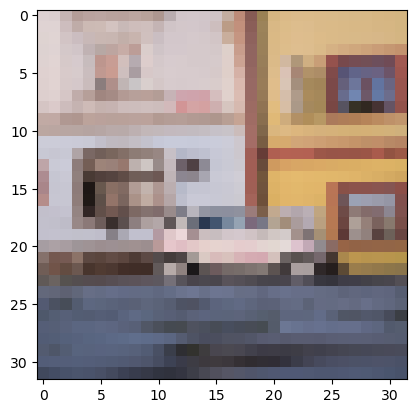

1


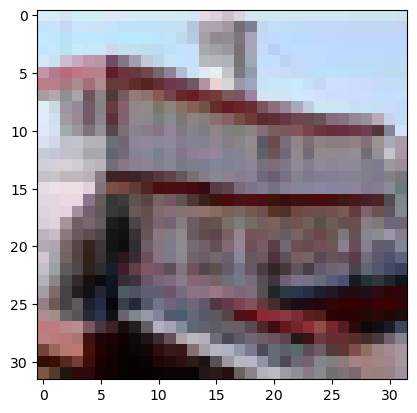

8


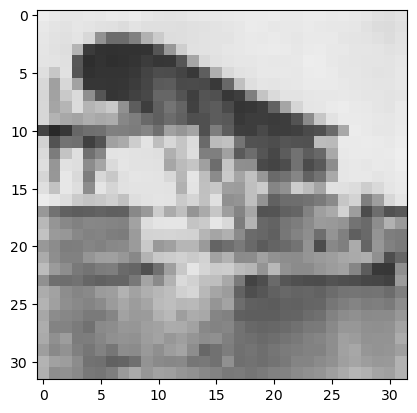

0


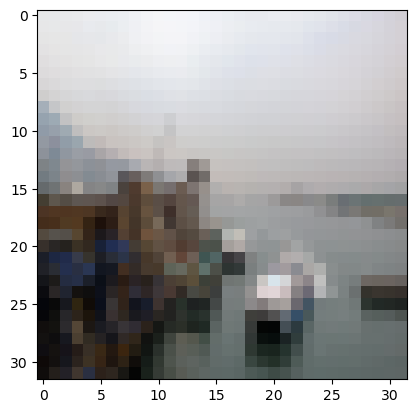

8


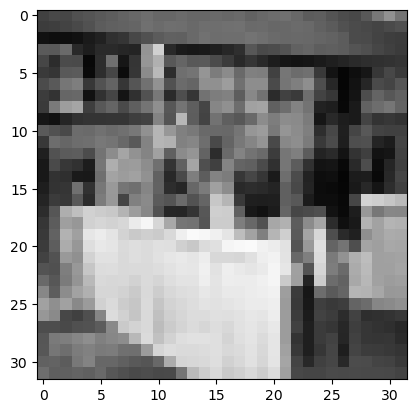

7


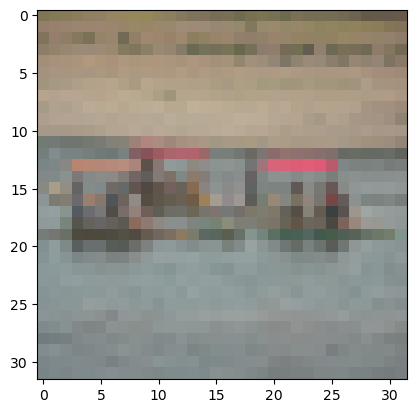

8


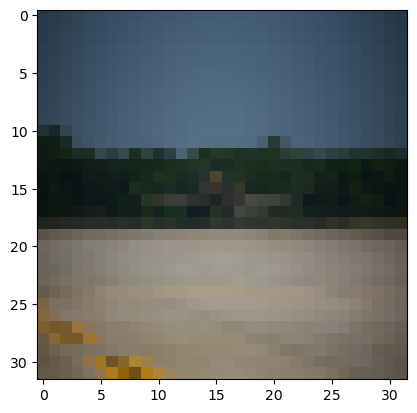

0


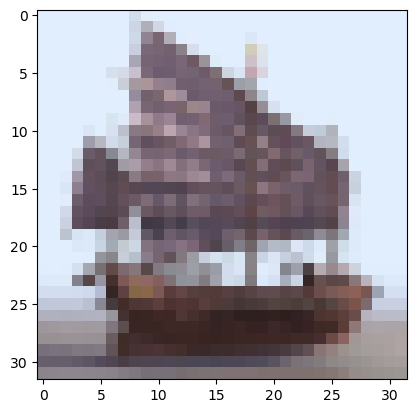

8


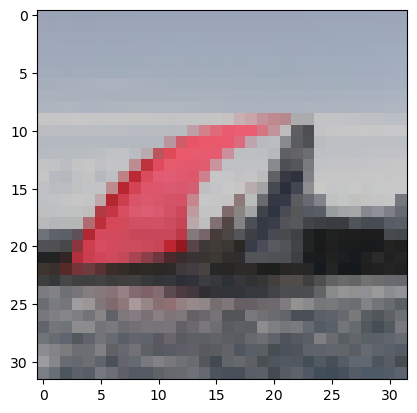

8


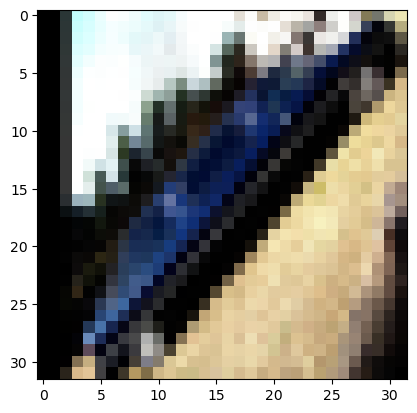

1


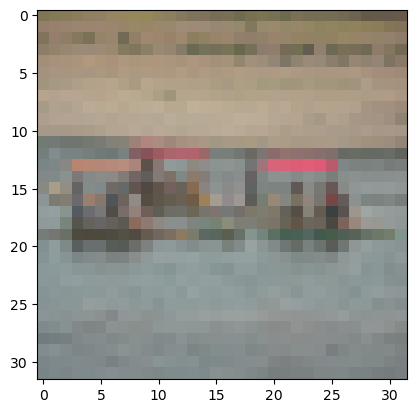

8


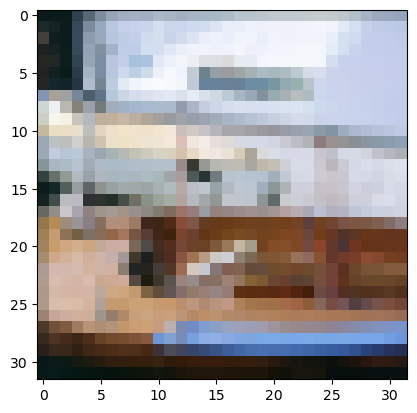

8


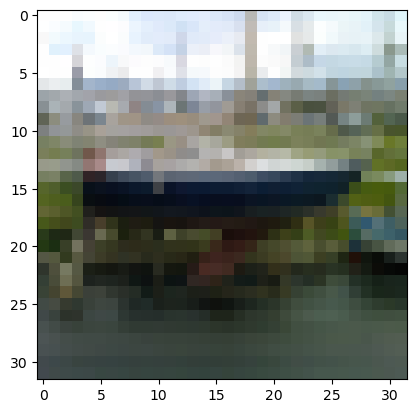

8


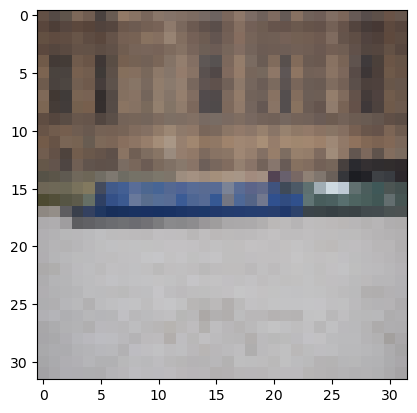

8


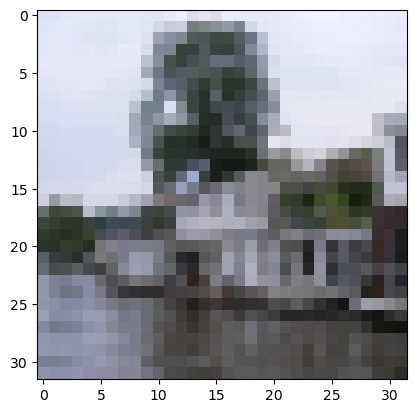

8


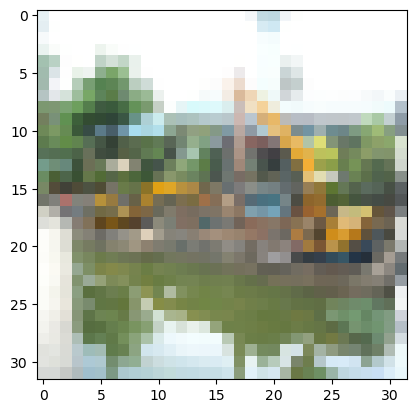

8


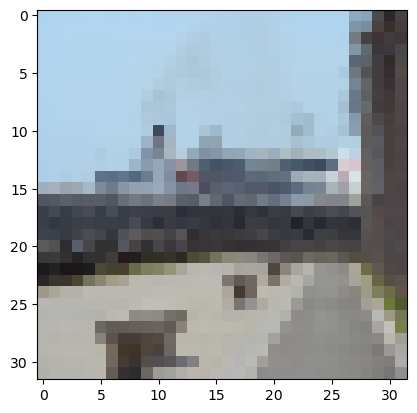

8


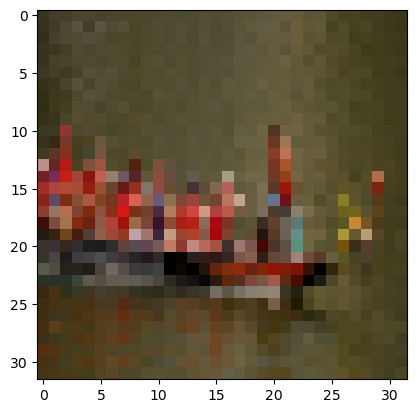

8


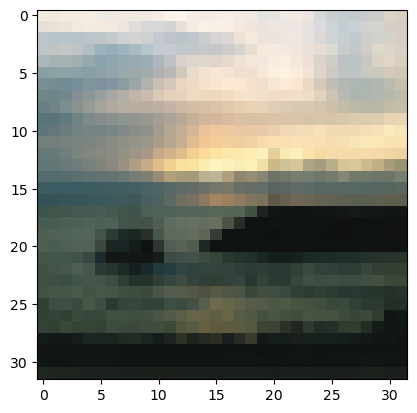

8


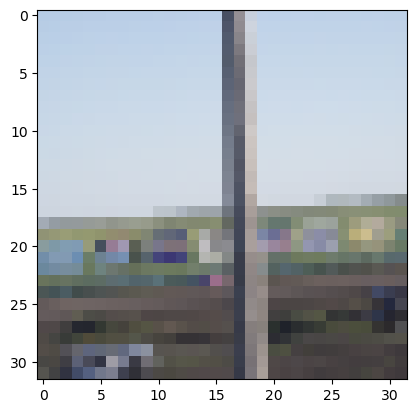

1


In [126]:
# for features
features_outputs = output['features']
features_image_paths = features_outputs['image_paths']
features_labels = features_outputs['labels']
for path, label in zip(neighbor_image_paths, neighbor_labels):
    image = load_image(path)
    image = np.transpose(image, (1, 2, 0))
    show_image(image)
    print(label)
    
logits_outputs = output['logits']
logits_image_paths = logits_outputs['image_paths']
logits_labels = logits_outputs['labels']
for path, label in zip(logits_image_paths, logits_labels):
    image = load_image(path)
    image = np.transpose(image, (1, 2, 0))
    show_image(image)
    print(label)

In [67]:
neighbor_image_paths = [image_paths[idx] for idx in indices[0]]
neighbor_labels = [labels[idx] for idx in indices[0]]
for path, label in zip(neighbor_image_paths, neighbor_labels):
    image = load_image(path)
    image = np.transpose(image, (1, 2, 0))
    show_image(image)
    print(label)

IndexError: list index out of range

 31%|███████████████████████████▊                                                             | 5/16 [00:00<00:01,  8.33it/s]

post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])


 81%|███████████████████████████████████████████████████████████████████████▌                | 13/16 [00:00<00:00, 19.21it/s]

post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])


100%|████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.27it/s]


post_features.shape torch.Size([40, 512, 1, 1])
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


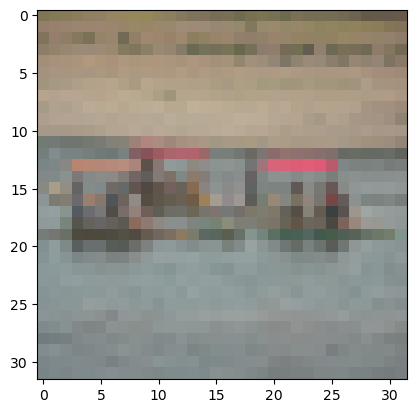

8


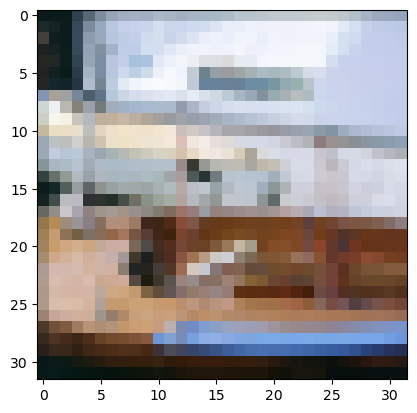

8


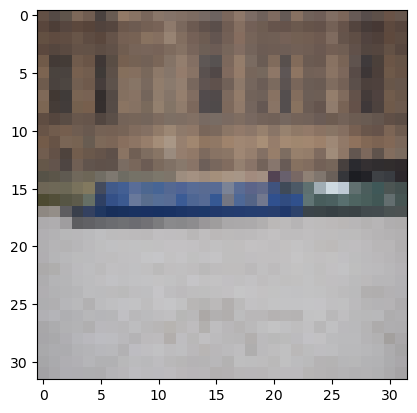

8


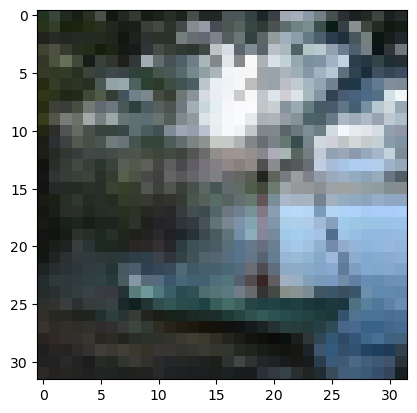

8


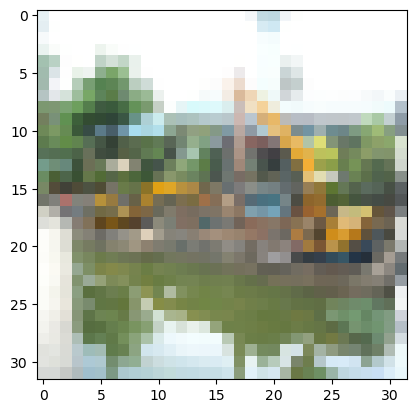

8


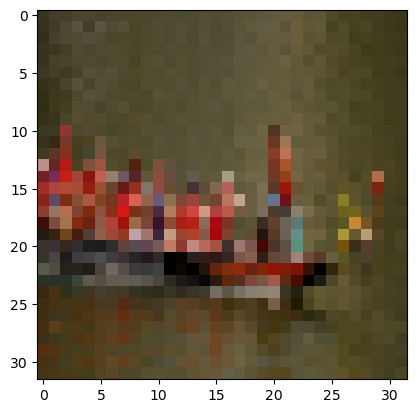

8


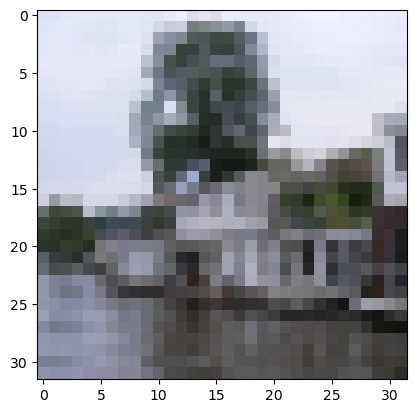

8


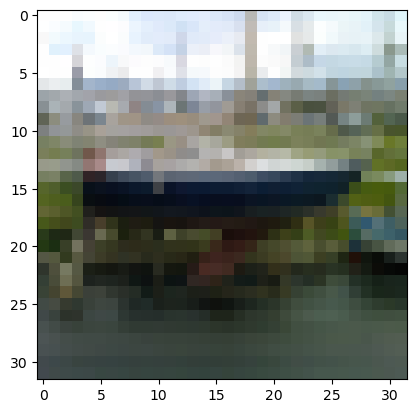

8


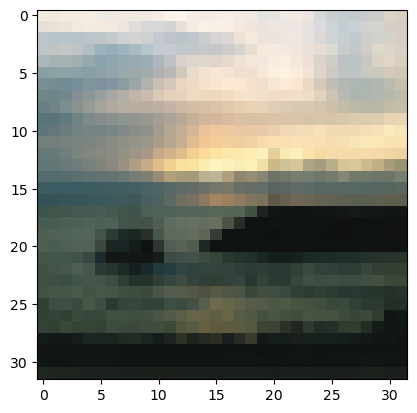

8


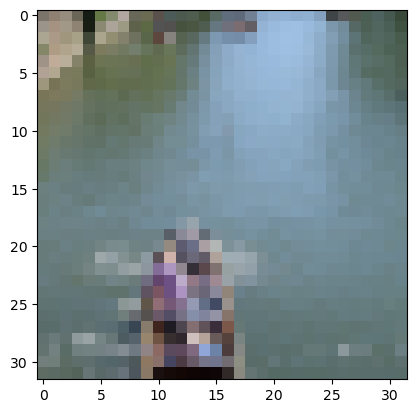

8


In [49]:
# Perform KNN for features
data_type = 'features'
all_data, labels, image_paths, base_data = prepare_knn(
    data_loader=val_data_loader,
    model=model,
    base_image=base_image,
    data_type=data_type
)

distances, indices = knn(
    K=K,
    data=all_data,
    labels=labels,
    point=base_data)

neighbor_image_paths = [image_paths[idx] for idx in indices[0]]
neighbor_labels = [labels[idx] for idx in indices[0]]
print(neighbor_labels)
for path, label in zip(neighbor_image_paths, neighbor_labels):
    image = load_image(path)
    image = np.transpose(image, (1, 2, 0))
    show_image(image)
    print(label)

100%|████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.85it/s]


[8, 8, 9, 5, 7, 0, 8, 9, 0, 7]


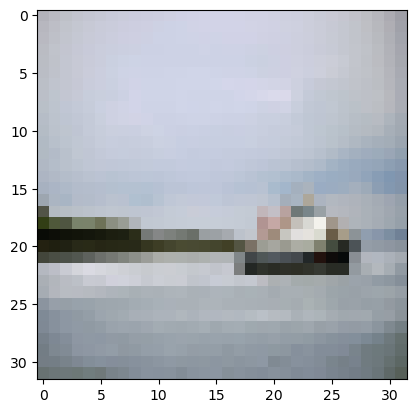

8


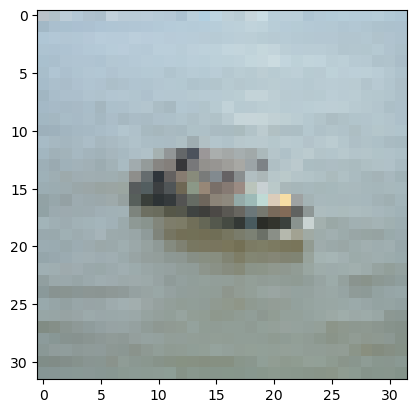

8


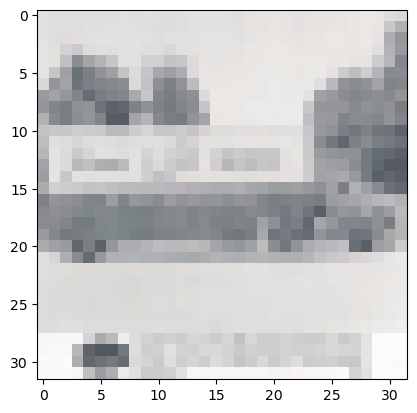

9


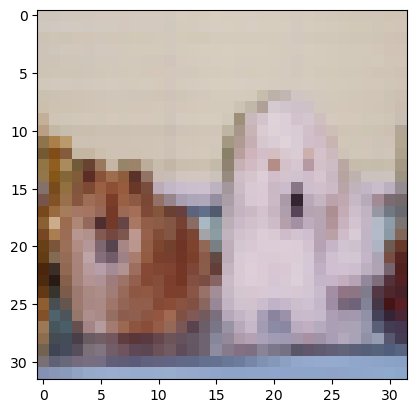

5


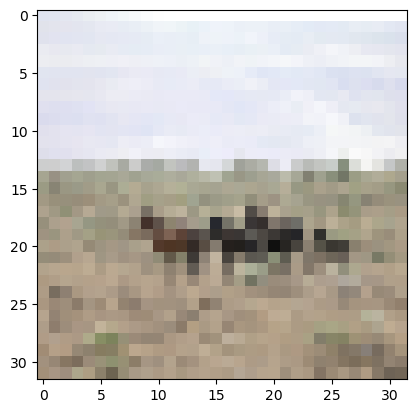

7


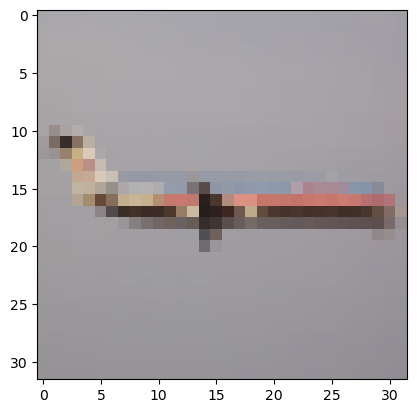

0


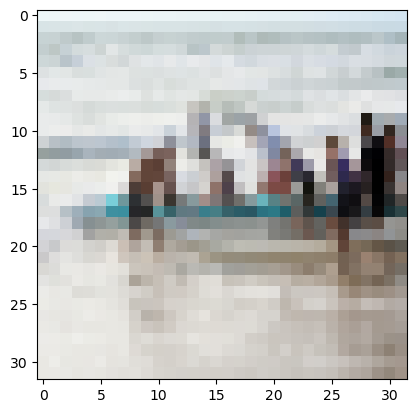

8


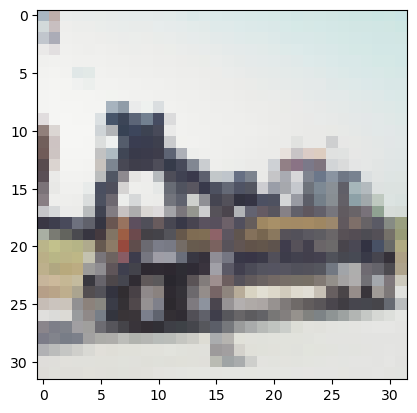

9


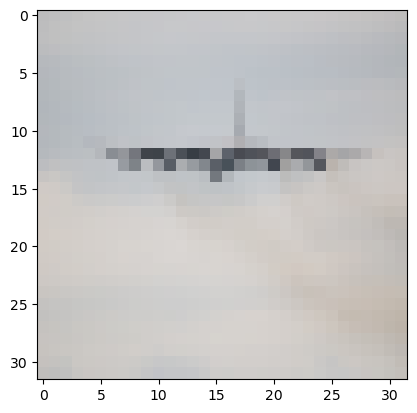

0


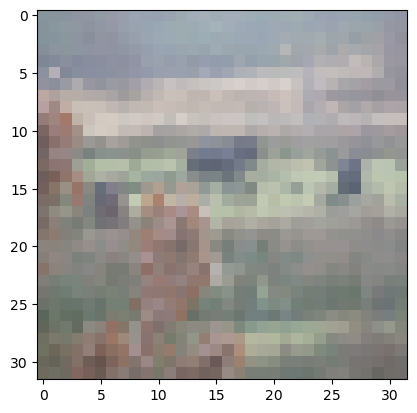

7


In [51]:
# Perform KNN for images
data_type = 'images'
all_data, labels, image_paths, base_data = prepare_knn(
    data_loader=val_data_loader,
    model=model,
    base_image=base_image,
    data_type=data_type
)

distances, indices = knn(
    K=K,
    data=all_data,
    labels=labels,
    point=base_data)

neighbor_image_paths = [image_paths[idx] for idx in indices[0]]
neighbor_labels = [labels[idx] for idx in indices[0]]
print(neighbor_labels)
for path, label in zip(neighbor_image_paths, neighbor_labels):
    image = load_image(path)
    image = np.transpose(image, (1, 2, 0))
    show_image(image)
    print(label)

100%|████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 20.31it/s]


[8, 8, 9, 5, 7, 0, 8, 9, 0, 7]


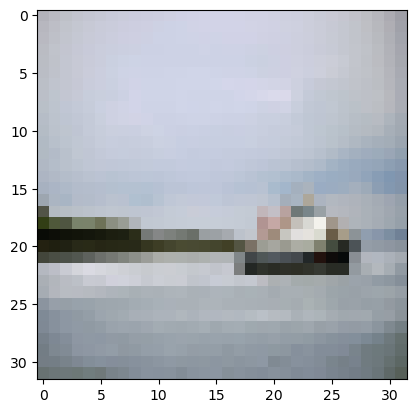

8


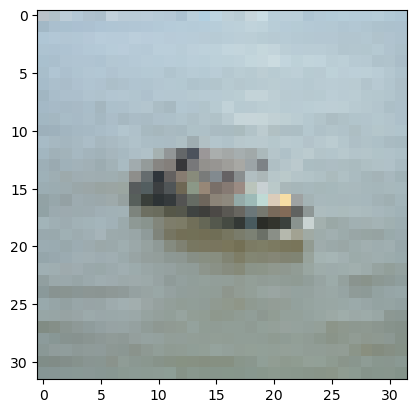

8


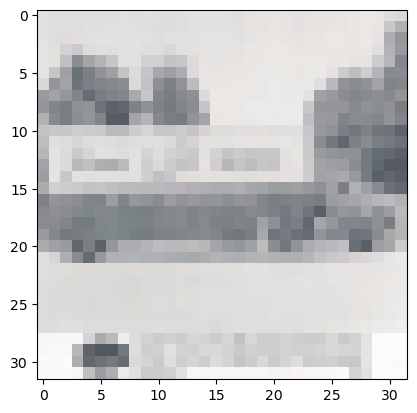

9


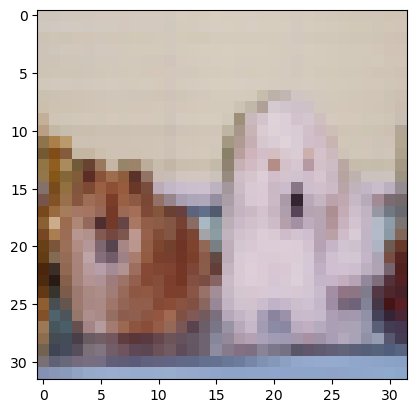

5


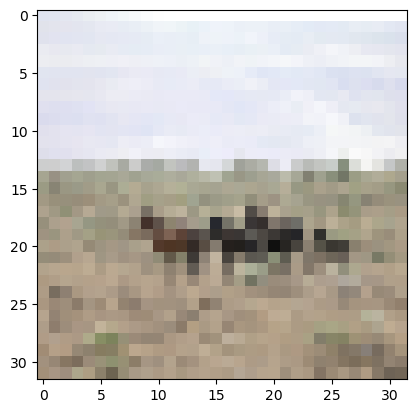

7


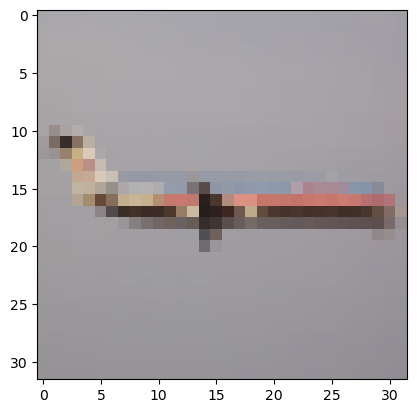

0


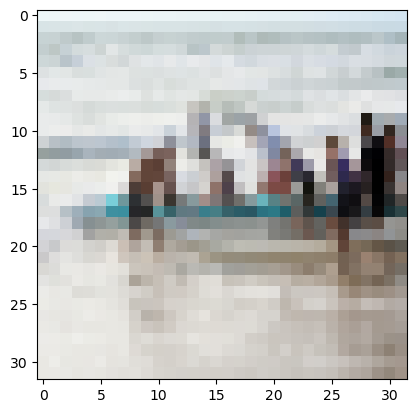

8


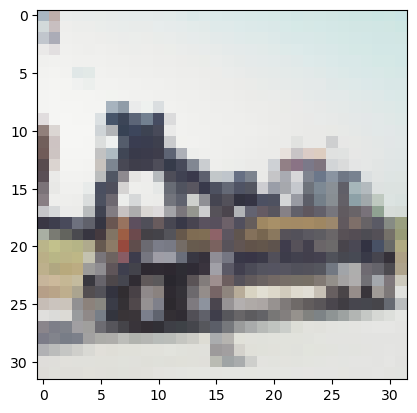

9


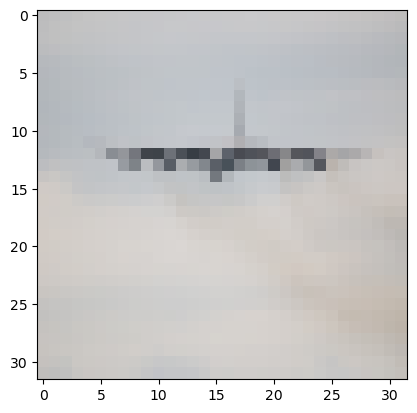

0


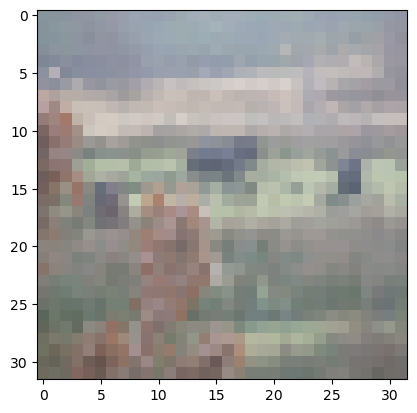

7


In [52]:
# Perform KNN for logits
data_type = 'images'
all_data, labels, image_paths, base_data = prepare_knn(
    data_loader=val_data_loader,
    model=model,
    base_image=base_image,
    data_type=data_type
)

distances, indices = knn(
    K=K,
    data=all_data,
    labels=labels,
    point=base_data)

neighbor_image_paths = [image_paths[idx] for idx in indices[0]]
neighbor_labels = [labels[idx] for idx in indices[0]]
print(neighbor_labels)
for path, label in zip(neighbor_image_paths, neighbor_labels):
    image = load_image(path)
    image = np.transpose(image, (1, 2, 0))
    show_image(image)
    print(label)